# Import required packages

In [1]:
#Import required packages

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from pyecharts import Bar
import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import warnings
warnings.filterwarnings('ignore')
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
from dotenv import load_dotenv
#import plotly.express as px
import openpyxl
import pymysql

from sqlalchemy import create_engine
from decouple import config 
from numpy import nan

In [2]:
end_date = '2022-09-30'
year = ['2021-2022', '2022-2023']
period = 'FY22Q2'

# Download databases

In [ ]:
#Connecting to Commcare
load_dotenv('id_cc.env')
email = os.getenv('COMCARE_EMAIL')
password = os.getenv('COMCARE_PASSWORD')

#Defining the driver
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.implicitly_wait(1000)

#-------------------------------------------------------------------------------------------------------------------------------------------

#Positive_kids_Information
def positive_kids():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/67352311fba5d3a5e285283aa4951676/"
    )
    driver.find_element(By.XPATH,'//*[@id="id_auth-username"]').send_keys(email)
    driver.find_element(By.XPATH,'//*[@id="id_auth-password"]').send_keys(password)
    driver.find_element(By.CSS_SELECTOR,'button[type=submit]').click()
    
positive_kids()

#Download positive database
driver.find_element(By.XPATH,"//*[@id='download-export-form']/form/div[2]/div/div[2]/div[1]/button/span[1]").click()
driver.find_element(By.XPATH,"//*[@id='download-progress']/div/div/div[2]/div[1]/form/a/span[1]").click()   
#-----------------------------------------------------------------------------------------------------------------------------------------

#OEV_kids_information

def oev_kids():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/690dc95932c1877d83a175978e1fa797/"
        )

oev_kids()
#Download oev database
driver.find_element(By.XPATH,'//*[@id="download-export-form"]/form/div[2]/div/div[2]/div[1]/button/span[1]').click()
driver.find_element(By.XPATH,'//*[@id="download-progress"]/div/div/div[2]/div[1]/form/a/span[1]').click()

#------------------------------------------------------------------------------------------------------------------------------------------

#Siblings
def siblings():
    driver.get(
    "https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/690dc95932c1877d83a175978efa7448/"
    )

siblings()

#Download siblings
driver.find_element(By.XPATH,'//*[@id="download-export-form"]/form/div[2]/div/div[2]/div[1]/button/span[1]').click()
driver.find_element(By.XPATH,'//*[@id="download-progress"]/div/div/div[2]/div[1]/form/a/span[1]').click()

#-------------------------------------------------------------------------------------------------------------------------------------------

def dreams_schooling():
    driver.get(
        'https://www.commcarehq.org/a/caris-test/data/export/custom/new/case/download/ae3ce02aad63402d0108435a413d38cb/'
    )

#Muso beneficiaries
dreams_schooling()

#Download the database "All gardens"
#driver.find_element_by_xpath('//*[@id="download-export-form"]/form/div[2]/div/div[2]/div[1]/button/span[1]').click()
driver.find_element(By.XPATH,"//*[@id='download-export-form']/form/div[2]/div/div[2]/div[1]/button/span[1]").click()
#driver.find_element_by_xpath('//*[@id="download-progress"]/div/div/div[2]/div[1]/form/a/span[1]').click()    
driver.find_element(By.XPATH,"//*[@id='download-progress']/div/div/div[2]/div[1]/form/a/span[1]").click()    


In [3]:
%%capture
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')

# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")

query = '''
SELECT 
    dm.id_patient as id_patient,
    d.case_id,
    p.patient_code AS code,
    d.a_non_patisipan_an AS first_name,
    d.b_siyati AS last_name,
    TIMESTAMPDIFF(YEAR,
        d.nan_ki_dat_ou_fet,
        now()) AS age,
    d.nan_ki_dat_ou_fet AS dob,
    d.a1_dat_entvyou_a_ft_jjmmaa_egz_010817 AS interview_date,
    d.e__telefn,
    d.d_adrs AS adress,
    IF(dm.id IS NOT NULL, 'yes', 'no') AS already_in_a_group,
    dm.id_group AS actual_id_group,
    dg.name AS actual_group_name,
    dm.id_parenting_group AS actual_id_parenting_group,
    dpg.name AS actual_parenting_group_name,
    dh.name AS actual_hub,
    ld.name AS actual_departement,
    d.f_komin AS commune,
    d.g_seksyon_kominal AS commune_section,
    d.b1_non_moun_mennen_entvyou_a AS interviewer_firstname,
    d.c1_siyati_moun_ki_f_entvyou_a AS interviewer_lastname,
    d.d1_kad AS interviewer_role,
    d.lot_kad AS interviewer_other_info,
    d.h_kote_entvyou_a_ft AS interview_location,
    d.paran_ou_vivan AS is_your_parent_alive,
    d.i_non_manman AS mothers_name,
    d.j_non_papa AS fathers_name,
    d.k_reskonsab_devan_lalwa AS who_is_your_law_parent,
    d.total,
    d.organisation,
    d.form_link
FROM
    caris_db.dreams_surveys_data d
        LEFT JOIN
    dream_member dm ON dm.case_id = d.case_id
        LEFT JOIN
    patient p ON p.id = dm.id_patient
        LEFT JOIN
    dream_group dg ON dg.id = dm.id_group
        LEFT JOIN
    dream_group dpg ON dpg.id = dm.id_parenting_group
        LEFT JOIN
    dream_hub dh ON dh.id = dg.id_dream_hub
        LEFT JOIN
    lookup_commune lc ON lc.id = dh.commune
        LEFT JOIN
    lookup_departement ld ON ld.id = lc.departement
'''

sdata= pd.read_sql_query(query,engine,parse_dates=True)
#sdata.id_patient = sdata.id_patient.astype(int16)
#sdata.age = sdata.age.astype(int16)
SDATA = sdata[sdata.total>=14]

# close the pool of connection
engine.dispose()

# Importing all databases

In [4]:
#Importing databases

positive = pd.read_excel(f"~/Downloads/schooling Enfant positif {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)
oev = pd.read_excel(f"~/Downloads/schooling oev {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)
siblings = pd.read_excel(f"~/Downloads/schooling sibling  {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", parse_dates = True)
dreams = pd.read_excel(f"~/Downloads/schooling_dreams {str(datetime.today().strftime('%Y-%m-%d'))}.xlsx")

In [5]:
dreams.rename(
    columns={
        'dreams_code':"code",
        "fullname":"not_fullname",
        "nom_patisipan_dreams":"fullname",
        "Office":"office",
        "infant_dob":"forget_dob"
    },
    inplace=True
)

dreams = dreams.merge(SDATA[['code','dob']],on="code",how="left")

# Data wrangling

In [6]:
#Rename some columns

positive.rename(columns = {'mention_reussie': 'eskew_pase'}, inplace = True)

oev.rename(columns = {'parent_patient_code':'patient_code',
                     'school_commune_1': 'school_commune',
                     'is_infant_success_school_year': 'eskew_pase'}, inplace = True)

siblings.rename(columns = {'parent_patient_code':'patient_code',
                           'is_infant_success_school_year': 'eskew_pase'}, inplace = True)

dreams.rename(columns = {'code':'patient_code',
                     'school_commune_1': 'school_commune',
                     'is_infant_success_school_year': 'eskew_pase',
                     'dob':"infant_dob"
                     }, inplace = True)


In [7]:
#---------------------------------------------------------------------------------------------------------------------------------------------------
#Add a categorical column
positive['type'] = 'positif'
oev['type'] = 'oev'
siblings['type'] = 'fratrie'
dreams['type'] = 'dreams'


positive['is_schooling_vouchers_elligible'] = nan
oev['is_schooling_vouchers_elligible'] = nan
siblings['is_schooling_vouchers_elligible'] = nan

#filtering
c_positive = positive[positive['schooling_year'].isin(year)]
c_positive = c_positive.drop_duplicates('patient_code').reset_index(drop = True)
c_oev = oev[oev['schooling_year'].isin(year)]
c_siblings = siblings[siblings['schooling_year'].isin(year)]
c_dreams = dreams[dreams['schooling_year'].isin(year)]

In [8]:

#---------------------------------------------------------------------------------------------------------------------------------------------------
#Subsets from main databases

# Interest columns
col = ['caseid', 'dat_peyman_fet','fullname', 'infant_dob', 'gender', 'infant_commune', 'type', 'office', 'patient_code', 'closed', 'school_commune', 
       'schooling_year', 'eskew_peye', 'eskew_pase', "siw_pa_peye_ki_rezon",'is_schooling_vouchers_elligible']

c_positive = c_positive[col]
c_oev = c_oev[col]
c_siblings = c_siblings[col]
c_dreams = c_dreams[col]

In [9]:




schooling_survey = pd.concat([c_positive,c_oev,c_siblings,c_dreams],ignore_index=True)
#schooling_data_1 = pd.concat([c_positive, c_oev])
#schooling_survey_0 = schooling_data_1.append(c_siblings).reset_index(drop=True)
#schooling_survey = schooling_survey_0.append(c_dreams).reset_index(drop=True)

# #---------------------------------------------------------------------------------------------------------------------------------------------------
#Creating age column
c_positive['infant_dob'] = pd.to_datetime(c_positive['infant_dob'], errors = 'coerce')
c_oev['infant_dob'] = pd.to_datetime(c_oev['infant_dob'], errors = 'coerce')
c_siblings['infant_dob'] = pd.to_datetime(c_siblings['infant_dob'], errors = 'coerce')
c_dreams.infant_dob.fillna("1901-01-01",inplace=True)
c_dreams['infant_dob'] = pd.to_datetime(c_dreams['infant_dob'], errors = 'coerce')


#FUnction 1
def get_age(date):
    return relativedelta(parse(end_date), date).years

#Function 2
def age_range(age):
    if age < 1:
        return '< 1'
    elif age in range(1, 5):
        return '1 - 4'
    elif age in range(5, 10):
        return '5 - 9'
    elif age in range(10, 15):
        return '10 - 14'
    elif age in range(15, 18):
        return '15 - 17'
    else:
        return '18+'


schooling_survey['infant_dob'] = pd.to_datetime(schooling_survey['infant_dob'], errors = 'coerce')
schooling_survey['age'] = schooling_survey['infant_dob'].map(get_age)
schooling_survey['age_range'] = schooling_survey['age'].map(age_range)


In [11]:
schooling_survey.eskew_pase.unique()
schooling_survey['eskew_pase'].fillna("---",inplace=True)
schooling_survey.eskew_pase.unique()

array(['non', 'wi', '---', 'wi_fra', 'non_fra', nan], dtype=object)

array(['non', 'wi', '---', 'wi_fra', 'non_fra'], dtype=object)

In [12]:
schooling_survey['eskew_pase'].replace(['wi_fra', 'non_fra','---'], ['wi', 'non','---'], inplace = True)

In [ ]:
%%capture
""" schooling_survey.loc[(schooling_survey.caseid=="776e79a8-5aa3-448a-bace-78b0cb6b5a01"),'gender'] = 2
schooling_survey.loc[(schooling_survey.caseid=="d6e46bbe-1afd-4d49-baab-31d8d62b54de"),'gender'] = 2
schooling_survey.loc[(schooling_survey.caseid=="c8f43474-104c-4f5b-8a2c-c1b6861a4177"),'gender'] = 2
schooling_survey.loc[(schooling_survey.caseid=="44a135b6-aac3-4735-8858-7698ff34295c"),'gender'] = 2
schooling_survey.loc[(schooling_survey.caseid=="8eb8f6a2-c5b3-4705-898f-fcfdb7e67b35"),'gender'] = 2
schooling_survey.loc[(schooling_survey.caseid=="bfca3538-9f60-416d-9e19-d9ee4d804a15"),'gender'] = 1
schooling_survey.loc[(schooling_survey.caseid=="2a427341-208b-447f-8354-c6c1b32b4fd5"),'gender'] = 1
schooling_survey.loc[(schooling_survey.caseid=="4fcd130f-218c-4866-a894-777db5c837cc"),'gender'] = 1
schooling_survey.loc[(schooling_survey.caseid=="cf9c7581-a0a2-4750-b519-8bfa3f3c5701"),'gender'] = 1 """

In [25]:
schooling_survey.gender.unique()
schooling_survey['gender'].replace([1,'1', '2','F',2,'2.0'], ['Male','Male', 'Female','Female','Female','Female'], inplace = True)
schooling_survey.gender.unique()

array(['2', '1', 2, 'F', '2.0', 1], dtype=object)

array(['Female', 'Male'], dtype=object)

In [28]:
schooling_survey[schooling_survey.office.isna()].infant_commune.unique()
schooling_survey[schooling_survey.office.isna()].school_commune.unique()

array(['Saint-Raphaël', 'Cap-Haïtien'], dtype=object)

array(['Saint-Raphaël', 'Cap-Haïtien'], dtype=object)

In [29]:
#--------------------------------------------------------------------------------------------------------------------------------------------------
schooling_survey.shape[0]
schooling_survey['office'].fillna('CAP', inplace = True)
schooling_survey.head(2)

4321

,caseid,dat_peyman_fet,fullname,infant_dob,gender,infant_commune,type,office,patient_code,closed,school_commune,schooling_year,eskew_peye,eskew_pase,siw_pa_peye_ki_rezon,is_schooling_vouchers_elligible,age,age_range
0,bce27881-c1cd-4367-ae84-b45479a99dac,2021-09-28,Seska Bien-Aime,2019-01-28,Female,Mombin-Crochu,positif,CAP,CAP/CSBL/ST00082,False,---,2021-2022,wi,non,---,NaN,3,1 - 4
1,c85955b8-efac-40fa-b666-ece8cbf2eb51,2021-09-28,Daika Bien-Aime,2009-05-07,Female,Mombin-Crochu,positif,CAP,CAP/CSBL/ST00083,False,---,2021-2022,wi,wi,---,NaN,13,10 - 14


In [30]:
schooling_survey.siw_pa_peye_ki_rezon = schooling_survey.siw_pa_peye_ki_rezon.str.replace(" ","")
schooling_survey.siw_pa_peye_ki_rezon = schooling_survey.siw_pa_peye_ki_rezon.str.lower()

# Surveyed kids

In [31]:
positive_surveyed = schooling_survey[schooling_survey['type'] == 'positif']
oev_surveyed = schooling_survey[schooling_survey['type'] == 'oev']
siblings_surveyed = schooling_survey[schooling_survey['type'] == 'fratrie']
dreams_surveyed = schooling_survey[schooling_survey['type'] == 'dreams']

df_surveyed = pd.DataFrame(data = [positive_surveyed.shape[0], oev_surveyed.shape[0], 
                                   siblings_surveyed.shape[0], dreams_surveyed.shape[0]], index = ['positive_surveyed', 'oev_surveyed', 'siblings_surveyed','dreams_surveyed'], 
                 columns = ['Total'])
df_surveyed.reset_index(inplace = True)
df_surveyed

,index,Total
0,positive_surveyed,1098
1,oev_surveyed,2171
2,siblings_surveyed,887
3,dreams_surveyed,165


In [32]:
df_surveyed['Total'].sum()

4321

# Barplot for surveyed kids

<AxesSubplot:xlabel='index', ylabel='Total'>

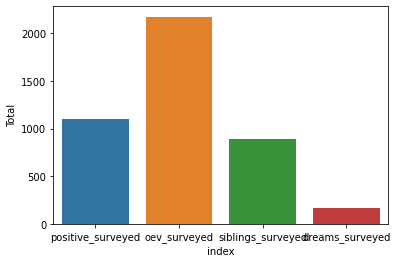

In [33]:
survey = sns.barplot(x='index', y='Total', data = df_surveyed)
survey

In [9]:
# plt.barh(df_surveyed['index'], df_surveyed['Total'])

# Schooling Beneficiaries

In [34]:
# siw_pa_peye_ki_rezon
raison_enfant_positif = [
    "AU",
    "Payé par parent",
    "payé par ONG compassion",
    "yon lot ONG PEYE pou li",
    "peye dèt 2020- 2021",
    "wi yo payé,nou poko jwenn reçu a",
    "Nou peye men nou poko jwenn resi a",
    "yo peye pou yo nou poko jwenn resi a",
    "nou peye,men nou poko genyen reçu a"
]

# siw_pa_peye_ki_rezon
raison_oev = [
    "AU",
    "Payé par parent",
    "lekol la peye men moun ki responsab pr pran fich depo a pa disponib",
    "wi yo peye,nou poko jwenn reçu a",
    "wi yo payé,nou poko jwenn reçu a"
]

# siw_pa_peye_ki_rezon
raison_siblings = [
    "AU",
    "li payé,men nou poko gen reçu pou li",
    "yon Lot ONG PEYE pou li",
    "wi yo payé,nou poko jwenn reçu a"
]

# siw_pa_peye_ki_rezon
touslesraisons = [
    "AU",
    "Payé par parent",
    "payé par ONG compassion",
    "peye dèt 2020- 2021",
    "wi yo payé,nou poko jwenn reçu a",
    "Nou peye men nou poko jwenn resi a",
    "yo peye pou yo nou poko jwenn resi a",
    "nou peye,men nou poko genyen reçu a",
    "Payé par parent",
    "lekol la peye men moun ki responsab pr pran fich depo a pa disponib",
    "wi yo peye,nou poko jwenn reçu a",
    "li payé,men nou poko gen reçu pou li",
    "yon Lot ONG PEYE pou li"
]


raison_enfant_positif = [item.replace(" ","") for item in raison_enfant_positif]
raison_oev = [item.replace(" ","") for item in raison_oev]
raison_siblings = [item.replace(" ","") for item in raison_siblings]
touslesraisons = [item.replace(" ","") for item in touslesraisons]

raison_enfant_positif = [item.lower() for item in raison_enfant_positif]
raison_oev = [item.lower() for item in raison_oev]
raison_siblings = [item.lower() for item in raison_siblings]
touslesraisons = [item.lower() for item in touslesraisons]


In [35]:
positive_surveyed[positive_surveyed.siw_pa_peye_ki_rezon.isin(raison_enfant_positif)].caseid.count()
oev_surveyed[oev_surveyed.siw_pa_peye_ki_rezon.isin(raison_oev)].caseid.count()
siblings_surveyed[siblings_surveyed.siw_pa_peye_ki_rezon.isin(raison_siblings)].caseid.count()


22

19

21

In [40]:


pos_benef = positive_surveyed[
       (positive_surveyed['eskew_peye'] == 'wi') |
       (positive_surveyed.siw_pa_peye_ki_rezon.isin(raison_enfant_positif))
]
oev_benef = oev_surveyed[
    (oev_surveyed['eskew_peye'] == 'wi') |
    (oev_surveyed.siw_pa_peye_ki_rezon.isin(raison_oev))
]
sib_benef = siblings_surveyed[
    (siblings_surveyed['eskew_peye'] == 'wi') |
    (siblings_surveyed.siw_pa_peye_ki_rezon.isin(raison_siblings))
]
dreams_benef = dreams_surveyed.query(
    'closed==False & eskew_peye=="1"'
)

df_benef = pd.DataFrame(data = [
    pos_benef.shape[0], 
    oev_benef.shape[0], 
    sib_benef.shape[0],
    dreams_benef.shape[0]
    ], 
    index = [
        'positive_benef',
        'oev_benef',
        'siblings_benef',
        'dreams_benef'
    ], 
    columns = ['Total']
)
df_benef.reset_index(inplace = True)
df_benef

,index,Total
0,positive_benef,1062
1,oev_benef,2036
2,siblings_benef,828
3,dreams_benef,153


In [41]:
df_benef['Total'].sum()

4079

In [42]:
pos_benef[pos_benef.siw_pa_peye_ki_rezon.isin(raison_enfant_positif)].caseid.count()
oev_benef[oev_benef.siw_pa_peye_ki_rezon.isin(raison_oev)].caseid.count()
sib_benef[sib_benef.siw_pa_peye_ki_rezon.isin(raison_siblings)].caseid.count()

22

19

21

# Bar plot for payment

<AxesSubplot:xlabel='index', ylabel='Total'>

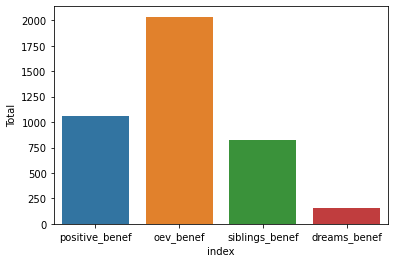

In [43]:
payment = sns.barplot(x='index', y='Total', data = df_benef)
payment

In [44]:
""" schooling_benef = schooling_survey[
    (schooling_survey['eskew_peye'] == 'wi') |
    (schooling_survey.siw_pa_peye_ki_rezon.isin(touslesraisons))
] """

schooling_benef = pd.concat([pos_benef,oev_benef,sib_benef,dreams_benef],ignore_index=True)
PT = schooling_benef.pivot_table(index = 'age_range', columns = 'type',values = 'caseid', aggfunc = len)

PT = PT.reindex(['< 1', '1 - 4', '5 - 9', '10 - 14', '15 - 17', '18+'])
PT.rename(columns = {'caseid': "Nombre de paiement enregistré"}, inplace = True)
PT = PT.append(PT.sum(numeric_only=True).rename('Total'))
# PT = PT.reindex(columns = columns)
PT

" schooling_benef = schooling_survey[\n    (schooling_survey['eskew_peye'] == 'wi') |\n    (schooling_survey.siw_pa_peye_ki_rezon.isin(touslesraisons))\n] "

type,dreams,fratrie,oev,positif
age_range,,,,
< 1,NaN,NaN,NaN,4.0
1 - 4,NaN,NaN,NaN,9.0
5 - 9,NaN,223.0,626.0,165.0
10 - 14,92.0,382.0,1062.0,426.0
15 - 17,43.0,165.0,285.0,230.0
18+,18.0,58.0,63.0,228.0
Total,153.0,828.0,2036.0,1062.0


In [45]:
Datim = schooling_benef.pivot_table(index = 'infant_commune', values = 'caseid', columns = ['gender', 'age_range'], aggfunc = len,
                                   margins = True, margins_name = 'Total')

columns = [('Female', '< 1'),
 ('Female', '1 - 4'),
 ('Female', '5 - 9'),
 ('Female', '10 - 14'),
 ('Female', '15 - 17'),
 ('Female', '18+'),
 ('Male', '< 1'),
 ('Male', '1 - 4'),
 ('Male', '5 - 9'),
 ('Male', '10 - 14'),
 ('Male', '15 - 17'),
 ('Male', '18+')]

Datim = Datim.reindex(columns = columns)
Datim.fillna(0, inplace = True)
# Datim.columns = ['_'.join(col) for col in Datim.columns.values]
# Datim.rename(columns = {'':'Co'})
Datim

gender          Female                                     Male               \
age_range          < 1 1 - 4  5 - 9 10 - 14 15 - 17    18+  < 1 1 - 4  5 - 9   
infant_commune                                                                 
Abricots           0.0   0.0    2.0     0.0     0.0    0.0  0.0   0.0    4.0   
Acul-du-Nord       0.0   0.0    0.0     0.0     0.0    0.0  0.0   0.0    1.0   
Anse-Rouge         0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    0.0   
Anse-d'Hainault    0.0   0.0    0.0     1.0     0.0    0.0  0.0   0.0    0.0   
Anse-à-Foleur      0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    1.0   
...                ...   ...    ...     ...     ...    ...  ...   ...    ...   
Torbeck            0.0   0.0    0.0     0.0     0.0    0.0  0.0   0.0    1.0   
Trou-du-Nord       0.0   0.0    8.0    21.0     5.0    0.0  0.0   0.0    6.0   
Verrettes          0.0   0.0    0.0     1.0     1.0    1.0  0.0   0.0    0.0   
Île-à-Vache        0.0   0.0    1.0     0.0     0.0    0.0  0.0   0.0    0.0   
Total              2.0   5.0  574.0  1097.0   418.0  198.0  2.0   4.0  440.0   

gender                                  
age_range       10 - 14 15 - 17    18+  
infant_commune                          
Abricots            0.0     1.0    0.0  
Acul-du-Nord        0.0     2.0    0.0  
Anse-Rouge          0.0     0.0    0.0  
Anse-d'Hainault     1.0     0.0    0.0  
Anse-à-Foleur       0.0     0.0    0.0  
...                 ...     ...    ...  
Torbeck             0.0     0.0    0.0  
Trou-du-Nord       10.0     5.0    2.0  
Verrettes           3.0     1.0    1.0  
Île-à-Vache         0.0     0.0    0.0  
Total             865.0   305.0  169.0  

[108 rows x 12 columns]

In [46]:
# Beneficiaries by office

office_surv = schooling_survey.pivot_table(index = 'office', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
office_surv.rename(columns = {'caseid': 'Questionnaire'}, inplace = True)

#-------------------------------------------------------------------------------------------------------------------
office_pay = schooling_benef.pivot_table(index = 'office', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
office_pay.rename(columns = {'caseid': 'Paiement'}, inplace = True)

office_data = office_surv.merge(office_pay, on = 'office', how = 'left')
# office_data.append(office_data.sum(numeric_only=True).rename('Total'))
office_data.reset_index(inplace = True)
# office_data['Pourcentage'] = round((office_data['Paiement']/office_data['Questionnaire'])*100, 0).astype(str) + '%'
# office_data

# office_data.append(office_data.sum(numeric_only=True), ignore_index=True)
# office_data['office'].replace('NaN', 'Total', inplace = True)

# office_data.reset_index(inplace = True)
office_data

,office,Questionnaire,Paiement
0,BOM,33,26
1,CAP,681,670
2,CAY,167,129
3,GON,242,234
4,JER,109,105
5,PAP,2911,2739
6,PDP,178,176
7,Total,4321,4079


In [47]:
data_desag = schooling_benef.pivot_table(index = 'office', columns = 'type', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
# data_desag.reset_index(inplace = True)
data_desag.fillna(0, inplace = True)
data_desag

type,dreams,fratrie,oev,positif,Total
office,,,,,
BOM,0.0,1.0,18.0,7.0,26
CAP,0.0,147.0,299.0,224.0,670
CAY,0.0,12.0,69.0,48.0,129
GON,0.0,35.0,90.0,109.0,234
JER,0.0,22.0,64.0,19.0,105
PAP,153.0,575.0,1434.0,577.0,2739
PDP,0.0,36.0,62.0,78.0,176
Total,153.0,828.0,2036.0,1062.0,4079


In [48]:
data_all = schooling_survey.pivot_table(index = 'office', columns = 'type', values = 'caseid', aggfunc = len, margins = True, margins_name = 'Total')
# data_all.reset_index(inplace = True)
data_all.fillna(0, inplace = True)
data_all

type,dreams,fratrie,oev,positif,Total
office,,,,,
BOM,0.0,4.0,22.0,7.0,33
CAP,0.0,152.0,304.0,225.0,681
CAY,0.0,15.0,79.0,73.0,167
GON,0.0,36.0,96.0,110.0,242
JER,0.0,22.0,66.0,21.0,109
PAP,165.0,621.0,1541.0,584.0,2911
PDP,0.0,37.0,63.0,78.0,178
Total,165.0,887.0,2171.0,1098.0,4321


In [49]:
schooling_benef_17 = schooling_benef[schooling_benef['age_range'] != '18+']
schooling_benef_17.shape[0]

3712

# Exporting output

In [50]:
#############

schooling_survey.to_excel(f"Schooling_data_consolidated_{period}_{str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", index = False)
#schooling_benef.to_excel(f"Schooling_data_consolidated_ALLPAYED_{period}_{str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", index = False)
Datim.to_excel('Datim_FY22Q2.xlsx')

In [51]:
import openpyxl

with pd.ExcelWriter(f"Data-Schooling_Commcare_{period}_{str(datetime.today().strftime('%Y-%m-%d'))}.xlsx", 
                    engine = 'openpyxl') as writer:
    office_data.to_excel(writer, sheet_name = 'Data_commcare', index = False)
    data_all.to_excel(writer, sheet_name = 'Survey_data')
    data_desag.to_excel(writer, sheet_name = 'Payment_data')

In [ ]:
schooling_benef.to_excel("./schooling_beneficiaries.xlsx",index=False)

In [ ]:
driver.quit()

---